In [1]:
from pathlib import Path
import numpy as np
import MDAnalysis as mda

from MDAnalysis import Universe
from MDAnalysis.topology.LAMMPSParser import DATAParser
from MDAnalysis.coordinates.PDB import PDBReader, PDBWriter
from MDAnalysis.topology.TOPParser import TOPParser
# from MDAnalysis.topology.PDBParser import PDBParser
# from MDAnalysis.topology.HoomdXMLParser import HoomdXMLParser

### Testing for mbuild pdb completion (filling in bonding info from other formats)

In [9]:
N = 10
mol_name = 'polyethylmethacrylate'
source_dir = Path(f'mbuild_polymers/PDB save test/{mol_name}')
file_stem = f'mbuild_{mol_name}'#-N={N}'

pdb_path    = source_dir/f'{file_stem}.pdb'
hoomd_path  = source_dir/f'{file_stem}.hoomdxml'
lammps_path = source_dir/f'{file_stem}.lmp'
gsd_path    = source_dir/f'{file_stem}.gsd'
top_path    = source_dir/f'{file_stem}.top'

# hoomd_parser = HoomdXMLParser(hoomd_path)
# hoomd_parser.parse()

lammps_parser = DATAParser(str(lammps_path))
topo = lammps_parser.parse()
# read = PDBReader(pdb_path)

u = Universe(topo, pdb_path) # use explicit topology but implicit trajectory (traj from pdb)

In [12]:
polymer = u.select_atoms('all')
outpath = source_dir/f'mda_{mol_name}.pdb'

with mda.Writer(outpath, multiframe=False) as pdb:
    pdb.write(polymer)

## Polymer Property Calculations

In [125]:
import matplotlib.pyplot as plt

def scatter_3D(array : np.array) -> None:
    x, y, z = array.T

    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    ax.scatter(x, y, z)

def compute_gyration_tensor(coords : np.ndarray, use_eins=True) -> np.ndarray:
    '''Determines the gyration tensor of a set of atomic coordinates (and its diagonalization)
    Expects coordinates in an Nx3 array, with each column representing the x, y, and z coordinates, respectively'''
    N, ncols = arr_shape = coords.shape
    if ncols != 3:
        raise ValueError(f'Coordinate array must be of shape Nx3, not {arr_shape}')

    COM = coords.mean(axis=0) # centre-of-mass coord
    rs = coords - COM # place origin at center of mass

    if use_eins: # use Einstein summation for notational and memory compactness
        gyr_tens = np.einsum('ij, ik->jk', rs, rs) / N 
    else: # use direct displacement summation, less efficient but easier to understand
        gyr_tens = np.zeros((3, 3))
        for point in rs:
            S_i = np.outer(point, point)
            gyr_tens += S_i
        gyr_tens /= N

    return gyr_tens

def diagonalize(matrix : np.ndarray) -> list[np.ndarray]:
    '''Performs eigendecomposition of a matrix
    Returns the basis and diagonal matrices as a list [P, D, P^-1]''' 
    eivals, eivecs = np.linalg.eig(matrix) # perform eigendecomposition to obtain principle components
    return [eivecs, np.diag(eivals), np.linalg.inv(eivecs)] # return vector containing P, D, and P^-1

def compute_Rg_and_K2(gyr_tens : np.ndarray, use_diag : bool=False) -> tuple[float, float]:
    '''Determine the radius of gyration (Rg) and radial shape anisotropy (K2) from a molecules gyration tensor'''
    if use_diag:
        P, D, P_inv = diagonalize(G)
        I1 = np.trace(D)
        I2 = (I1**2 - np.trace(D**2)) / 2
    else:
        S, _eivecs = np.linalg.eig(G)
        I1 = S.sum()
        I2 = (I1**2 - np.sum(S**2)) / 2

    Rg = np.sqrt(I1)
    K2 = 1 - 3*(I2 / I1**2)
    
    return Rg, K2


4.891259843088864 
 4.588774 0.29499575911960374


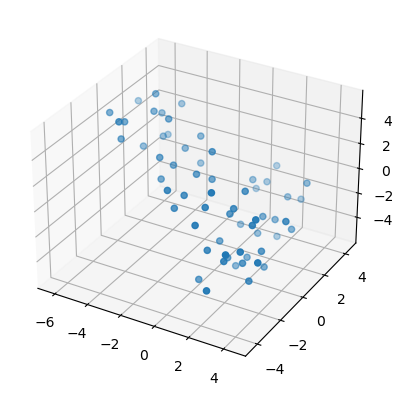

In [128]:
traj_path = Path('averaged_polymers/polyvinylchloride/polyvinylchloride_frames.pdb')

u = Universe(traj_path)
coords = np.array([atom.position for atom in u.atoms])
scatter_3D(coords)

Rg1 = u.atoms.radius_of_gyration()
G = compute_gyration_tensor(coords)
Rg2, K2 = compute_Rg_and_K2(G)

print(Rg1, '\n', Rg2, K2)